In [128]:
# Import libraries and dependencies
import pandas as pd
from pathlib import Path
import numpy as np
import hvplot.pandas  # noqa
import hvplot.dask  # noqa
from statsmodels.tsa.arima.model import ARIMA
%matplotlib inline

In [129]:
# Read CSV, parse dates, and set index
csvpath = Path('./Resources/GHG_Econ_Can_Prov_Terr.csv')
df = pd.read_csv(csvpath, parse_dates=True, index_col='Year', infer_datetime_format=True)
df.head()

,Region,Index,Source,Category,Sub-category,Sub-sub-category,Total,CO2eq,Unit
Year,,,,,,,,,
1990-01-01,Alberta,0,Provincial Inventory Total,NaN,NaN,NaN,y,171.7849588,Mt
1990-01-01,Alberta,1,Oil and Gas,NaN,NaN,NaN,y,65.21309573,Mt
1990-01-01,Alberta,2,Oil and Gas,Upstream Oil and Gas,NaN,NaN,y,61.57702554,Mt
1990-01-01,Alberta,3,Oil and Gas,Upstream Oil and Gas,Natural Gas Production and Processing,NaN,NaN,27.83228536,Mt
1990-01-01,Alberta,4,Oil and Gas,Upstream Oil and Gas,Conventional Oil Production,NaN,y,15.26101044,Mt


## Know more about the data file

In [130]:
df['Source']

Year
1990-01-01    Provincial Inventory Total
1990-01-01                   Oil and Gas
1990-01-01                   Oil and Gas
1990-01-01                   Oil and Gas
1990-01-01                   Oil and Gas
                         ...            
2019-01-01                     Buildings
2019-01-01                     Buildings
2019-01-01                         Waste
2019-01-01                         Waste
2019-01-01                         Waste
Name: Source, Length: 16825, dtype: object

In [131]:
total_provincal_ghg = df[df['Source'] == 'Provincial Inventory Total']
total_provincal_ghg.drop(columns=['Index', 'Source','Category','Sub-category','Sub-sub-category', 'Total','Unit'], inplace=True)

total_canada_ghg = df[df['Source'] == 'National Inventory Total']
total_canada_ghg.drop(columns=['Index', 'Source','Category','Sub-category','Sub-sub-category', 'Total','Unit'], inplace=True)

C:\Users\Yau Hei Chan\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [132]:
total_provincal_ghg.head()

,Region,CO2eq
Year,,
1990-01-01,Alberta,171.7849588
1991-01-01,Alberta,172.9444695
1992-01-01,Alberta,180.9919743
1993-01-01,Alberta,186.7214107
1994-01-01,Alberta,196.1613682


In [133]:
total_canada_ghg.head()

,Region,CO2eq
Year,,
1990-01-01,Canada,601.5236931
1991-01-01,Canada,595.7767263
1992-01-01,Canada,613.5906402
1993-01-01,Canada,616.7983943
1994-01-01,Canada,638.0004703


In [134]:
region_names = total_provincal_ghg['Region'].unique()
region_names

array(['Alberta', 'British Columbia', 'Manitoba', 'New Brunswick',
       'Newfoundland and Labrador', 'Nova Scotia', 'Ontario',
       'Prince Edward Island', 'Quebec', 'Saskatchewan'], dtype=object)

In [135]:
total_provincal_ghg.head()

,Region,CO2eq
Year,,
1990-01-01,Alberta,171.7849588
1991-01-01,Alberta,172.9444695
1992-01-01,Alberta,180.9919743
1993-01-01,Alberta,186.7214107
1994-01-01,Alberta,196.1613682


In [136]:
# Convert CO2eq into Numerical data 
total_provincal_ghg['CO2eq']= pd.to_numeric(total_provincal_ghg['CO2eq'])
total_canada_ghg['CO2eq']= pd.to_numeric(total_canada_ghg['CO2eq'])

C:\Users\YAUHEI~1\AppData\Local\Temp/ipykernel_25856/1879997057.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_provincal_ghg['CO2eq']= pd.to_numeric(total_provincal_ghg['CO2eq'])
C:\Users\YAUHEI~1\AppData\Local\Temp/ipykernel_25856/1879997057.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_canada_ghg['CO2eq']= pd.to_numeric(total_canada_ghg['CO2eq'])


In [137]:
# Visualize ghg annual total by region

total_provincal_ghg.hvplot(groupby='Region')

:DynamicMap   [Region]
   :Curve   [Year]   (CO2eq)

In [138]:
# Visualize total ghg output in Canada and respective contribution by region
total_provincal_ghg.hvplot.area(by='Region')

:NdOverlay   [Region]
   :Area   [Year]   (CO2eq,Baseline)

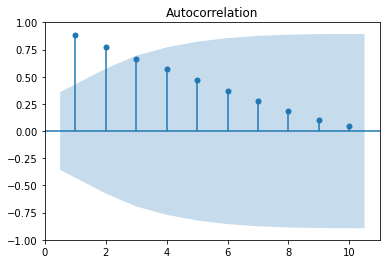

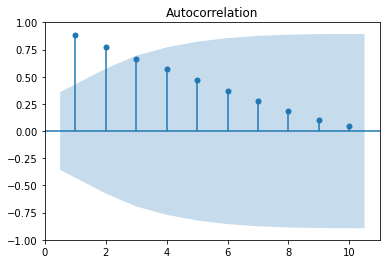

In [139]:
# Plot ACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
df = total_provincal_ghg.where(total_provincal_ghg['Region'] == 'Alberta').dropna()
plot_acf(df['CO2eq'], zero=False, lags=10)

C:\Users\Yau Hei Chan\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


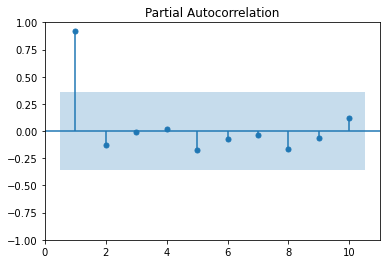

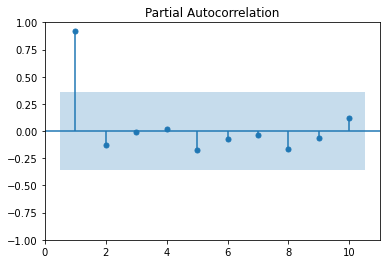

In [140]:
# Plot PACF
plot_pacf(df['CO2eq'], zero=False, lags=10)

## Run ARIMA for AB, BC, ON, and all of Canada

In [143]:
# construct a dataframe with all relevant data
total_ghg = total_canada_ghg.rename(columns={'CO2eq':'Canada'})
total_ghg.drop(columns=['Region'], inplace=True)
total_ghg.head()

,Canada
Year,
1990-01-01,601.523693
1991-01-01,595.776726
1992-01-01,613.590640
1993-01-01,616.798394
1994-01-01,638.000470


In [147]:
region_of_interest = ['Alberta', 'British Columbia', 'Ontario']

for r in region_of_interest:
    df = total_provincal_ghg.where(total_provincal_ghg['Region'] == r).dropna()
    df.rename(columns={'CO2eq':r}, inplace=True)
    df = df.drop(columns=['Region'])
    total_ghg = pd.concat([total_ghg, df], axis=1)

total_ghg.head()


,Canada,Alberta,British Columbia,Ontario
Year,,,,
1990-01-01,601.523693,171.784959,51.783130,180.048102
1991-01-01,595.776726,172.944469,50.882715,179.469093
1992-01-01,613.590640,180.991974,50.126933,182.898674
1993-01-01,616.798394,186.721411,53.160821,173.161361
1994-01-01,638.000470,196.161368,56.092659,175.479083


In [149]:
import warnings
warnings.filterwarnings("ignore")

In [157]:
# Run ARIMA model of each region
from statsmodels.tsa.arima.model import ARIMA
arima_results = {}
for col in total_ghg.columns:
    # AR look at pacf graph but do not use seasonality peaks
    model = ARIMA(total_ghg[col],  dates=df.index, order=(2, 1, 2))
    # Fit the model
    arima_results.update({col : ARIMA.fit(model)})
    # order is (AR, I, MA)

arima_results

{'Canada': <statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x141580d2e80>,
 'Alberta': <statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x141580eafa0>,
 'British Columbia': <statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x141580eaf10>,
 'Ontario': <statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x1415813e2e0>}

In [173]:
arima_results['Canada'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Canada   No. Observations:                   30
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -117.810
Date:                Sat, 04 Dec 2021   AIC                            245.621
Time:                        22:27:28   BIC                            252.457
Sample:                    01-01-1990   HQIC                           247.762
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1309      0.448      0.292      0.770      -0.746       1.008
ar.L2          0.6514      0.249      2.612      0.009       0.163       1.140
ma.L1          0.2079     34.370      0.006      0.995     -67.156      67.572
ma.L2         -0.7917     27.166     -0.029      0.977     -54.036      52.452
sigma2       186.1683   6355.123      0.029      0.977   -1.23e+04    1.26e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):                 4.80
Prob(Q):                              0.61   Prob(JB):                         0.09
Heteroskedasticity (H):               0.45   Skew:                            -0.91
Prob(H) (two-sided):                  0.22   Kurtosis:                         3.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [178]:
# Display model summary
summary = {}
for key in arima_results.keys():
    print(f'\nARIMA result smmary for : {key}')
    summary.update({key: arima_results[key].summary()})
    print(summary[key].as_text())


ARIMA result smmary for : Canada
                               SARIMAX Results                                
Dep. Variable:                 Canada   No. Observations:                   30
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -117.810
Date:                Sat, 04 Dec 2021   AIC                            245.621
Time:                        22:36:35   BIC                            252.457
Sample:                    01-01-1990   HQIC                           247.762
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1309      0.448      0.292      0.770      -0.746       1.008
ar.L2          0.6514      0.249      2.612      0.009       0.163       1.140
ma.L1          0.2

In [207]:
# Visualize the forecast
#for key in arima_results:
#    pd.DataFrame(arima_results[key].forecast(steps=12)).plot(title=f'GHG Emission Forecast of {key}')
pd.DataFrame(arima_results['Canada'].forecast(steps=11)).hvplot(title=f'GHG Emission Forecast of Canada', xlabel='Year')

:Curve   [index]   (predicted_mean)

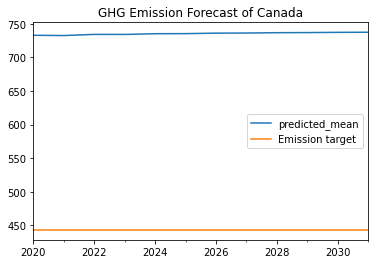

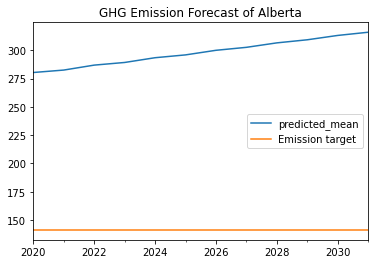

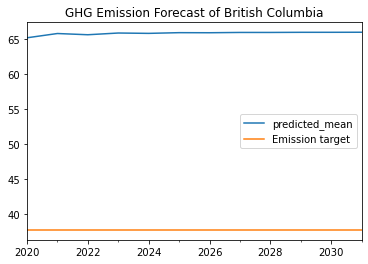

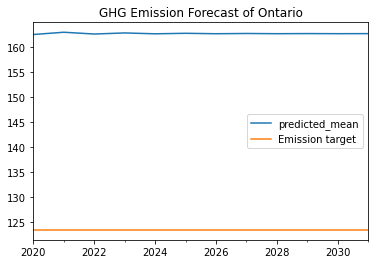

In [202]:
# Visualize result with 2030 target emission
for key in arima_results:
    df = pd.DataFrame(arima_results[key].forecast(steps=12))
    df['Emission target'] = 0.6*total_ghg[key].loc['2005-01-01']
    df.plot(title=f'GHG Emission Forecast of {key}')
